In [1]:
%load_ext rich

# Basic Imports
import torch
import pytorch_lightning as pl
import numpy as np
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint

import vector
import tree
from rich import progress

In [2]:
from spanet import Options ,JetReconstructionModel
# from helper import *

In [33]:
from helper import *

In [3]:
USE_GPU = True

## Load Option

In [4]:
options = Options.load("options_SPANet_modified_08_02.json")
options.display()

                                Configuration                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Parameter                          ┃ Value                                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ assignment_loss_scale              │ 1.0                                   │
│ balance_classifications            │ 0                                     │
│ balance_jets                       │ 0                                     │
│ balance_losses                     │ 1                                     │
│ balance_particles                  │ 0                                     │
│ batch_size                         │ 512                                   │
│ classification_loss_scale          │ 0.0                                   │
│ combinatorial_scale                │ 0.0                                   │
│ combine_pair_loss                  │ min                                   │
│ dataset_limit                      │ 1.0                                   │
│ dataset_randomization              │ 0                                     │
│ detection_loss_scale               │ 1.0                                   │
│ dropout                            │ 0.2                                   │
│ epochs                             │ 500                                   │
│ event_info_file                    │ semi_leptonic_ttbar.yaml              │
│ focal_gamma                        │ 1.0                                   │
│ gradient_clip                      │ 0.0                                   │
│ hidden_dim                         │ 128                                   │
│ initial_embedding_dim              │ 16                                    │
│ initial_embedding_skip_connections │ 1                                     │
│ kl_loss_scale                      │ 0.0                                   │
│ l2_penalty                         │ 0.0002                                │
│ learning_rate                      │ 0.0015                                │
│ learning_rate_cycles               │ 1                                     │
│ learning_rate_warmup_epochs        │ 1.0                                   │
│ limit_to_num_jets                  │ 0                                     │
│ linear_activation                  │ gelu                                  │
│ linear_block_type                  │ GRU                                   │
│ linear_prelu_activation            │ 1                                     │
│ mask_sequence_vectors              │ 1                                     │
│ masking                            │ Filling                               │
│ normalization                      │ LayerNorm                             │
│ normalize_features                 │ 1                                     │
│ num_attention_heads                │ 4                                     │
│ num_branch_embedding_layers        │ 3                                     │
│ num_branch_encoder_layers          │ 3                                     │
│ num_classification_layers          │ 3                                     │
│ num_dataloader_workers             │ 16                                    │
│ num_detector_layers                │ 2                                     │
│ num_embedding_layers               │ 10                                    │
│ num_encoder_layers                 │ 8                                     │
│ num_gpu                            │ 4                                     │
│ num_jet_embedding_layers           │ 0                                     │
│ num_jet_encoder_layers             │ 2                                     │
│ num_regression_layers              │ 4                                     │
│ optimizer                          │ AdamW                                 │
│ partial_events                     │ 1          

In [5]:
options_2 = Options.load("options_SPANet_modified_07_03.json")
options_2.display()

                                     Configuration                                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Parameter                          ┃ Value                                          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ assignment_loss_scale              │ 1.0                                            │
│ balance_classifications            │ 0                                              │
│ balance_jets                       │ 0                                              │
│ balance_losses                     │ 1                                              │
│ balance_particles                  │ 0                                              │
│ batch_size                         │ 512                                            │
│ classification_loss_scale          │ 0.0                                            │
│ combinatorial_scale                │ 0.0                                            │
│ combine_pair_loss                  │ min                                            │
│ dataset_limit                      │ 1.0                                            │
│ dataset_randomization              │ 0                                              │
│ detection_loss_scale               │ 1.0                                            │
│ dropout                            │ 0.2                                            │
│ epochs                             │ 500                                            │
│ event_info_file                    │ semi_leptonic_ttbar.yaml                       │
│ focal_gamma                        │ 1.0                                            │
│ gradient_clip                      │ 0.0                                            │
│ hidden_dim                         │ 128                                            │
│ initial_embedding_dim              │ 16                                             │
│ initial_embedding_skip_connections │ 1                                              │
│ kl_loss_scale                      │ 0.0                                            │
│ l2_penalty                         │ 0.0002                                         │
│ learning_rate                      │ 0.0015                                         │
│ learning_rate_cycles               │ 1                                              │
│ learning_rate_warmup_epochs        │ 1.0                                            │
│ limit_to_num_jets                  │ 0                                              │
│ linear_activation                  │ gelu                                           │
│ linear_block_type                  │ GRU                                            │
│ linear_prelu_activation            │ 1                                              │
│ mask_sequence_vectors              │ 1                                              │
│ masking                            │ Filling                                        │
│ normalization                      │ LayerNorm                                      │
│ normalize_features                 │ 1                                              │
│ num_attention_heads                │ 4                                              │
│ num_branch_embedding_layers        │ 3                                              │
│ num_branch_encoder_layers          │ 3                                              │
│ num_classification_layers          │ 3                                              │
│ num_dataloader_workers             │ 16                                             │
│ num_detector_layers                │ 2                                              │
│ num_embedding_layers               │ 10                                             │
│ num_encoder_layers                 │ 8                                              │
│ num_gpu                            │ 4

## Model Construction & Preload Trained Model

In [6]:
model = JetReconstructionModel.load_from_checkpoint(
    "lightning_logs/SPANet_modified_08_02/checkpoints/best-checkpoint.ckpt",
    map_location="cpu", 
    options=options
)

if USE_GPU:
    model = model.cuda()
    
model = model.eval()
for parameter in model.parameters():
    parameter.requires_grad_(False) #what if require_grad is false


Index Range: 0...1653124
Index Range: 1653125...1740131
Index Range: 0...440690


In [7]:
print('Number of testing events:', model.testing_dataset.num_events)
print('Number of training events:', model.training_dataset.num_events) #both from truncated num_events file

Number of testing events: 440691
Number of training events: 1653125


In [8]:
model_2 = JetReconstructionModel.load_from_checkpoint(
    "lightning_logs/SPANet_modified_07_03/checkpoints/best-checkpoint.ckpt",
    map_location="cpu", 
    options=options_2
)

if USE_GPU:
    model_2 = model_2.cuda()
    
model_2 = model_2.eval()
for parameter in model_2.parameters():
    parameter.requires_grad_(False) #what if require_grad is false


Index Range: 0...1281579
Index Range: 1281580...1349031
Index Range: 0...829976


In [9]:
print('Number of testing events:', model_2.testing_dataset.num_events)
print('Number of training events:', model_2.training_dataset.num_events) #both from truncated num_events file

Number of testing events: 829977
Number of training events: 1281580


## Model Evalutaion

Output()

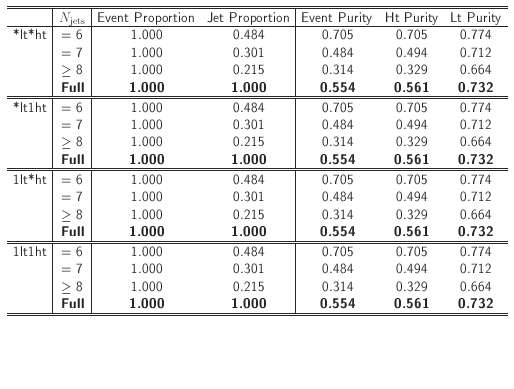

In [10]:
from spanet.evaluation import evaluate_on_test_dataset

evaluation = evaluate_on_test_dataset(model)
display_results_table(model, evaluation)

Output()

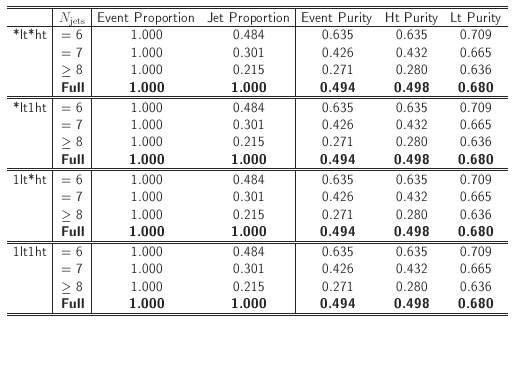

In [11]:
evaluation_2 = evaluate_on_test_dataset(model_2)
display_results_table(model_2, evaluation_2)

## Top Quarks Mass Estimatation

In [12]:
momenta = model.testing_dataset.sources["Momenta"].source_data
momenta_mask = model.testing_dataset.sources['Momenta'][:].mask #jet_level_mask for each event
lt_truth, lt_mask = model.testing_dataset.assignments["lt"]
ht_truth, ht_mask = model.testing_dataset.assignments["ht"]

In [13]:
# momenta[0]

In [14]:
# ht_truth, ht_mask

In [15]:
# lt_truth, lt_mask

In [16]:
# momenta_mask

In [17]:
momenta_2 = model_2.testing_dataset.sources["Momenta"].source_data
momenta_mask_2 = model_2.testing_dataset.sources['Momenta'][:].mask #jet_level_mask for each event
lt_truth_2, lt_mask_2 = model_2.testing_dataset.assignments["lt"]
ht_truth_2, ht_mask_2 = model_2.testing_dataset.assignments["ht"]

In [18]:
def random_assignment(jet_level_mask):
    """
    Generates random unique indices for 'lt' and 'ht' for each event, excluding index 0 (lepton).
    
    Parameters:
    mask (np.array): Boolean tensor of shape [N, 17] indicating real jets (True) and fake jets (False).

    Returns:
    dict: A dictionary with keys 'lt' and 'ht' containing the randomly generated indices.
    """
    num_events = jet_level_mask.shape[0]
    assignments = {'lt':[], 'ht':[]}
    for i in range(num_events):
        real_jet_indices = np.where(jet_level_mask[i])[0] #getting real jets indices [0, 1, 2, 3, 4,...]
        real_jet_indices = real_jet_indices[real_jet_indices != 0] #exclude 0 index out of random indices because lepton indices is always one. We want leptonic/hadronic top quarks

        chosen_indices = np.random.choice(real_jet_indices, size=4, replace=False) #technically rearrange, assign random indices
        lt_index = chosen_indices[0]
        ht_indices = chosen_indices[1:]

        assignments['lt'].append([lt_index])
        assignments['ht'].append(ht_indices)

    # Convert lists to numpy arrays
    assignments['lt'] = np.array(assignments['lt'])
    assignments['ht'] = np.array(assignments['ht'])
    
    return assignments

In [19]:
random_evaluation = random_assignment(momenta_mask)

In [20]:
random_evaluation_2 = random_assignment(momenta_mask_2)

In [21]:
# momenta[0][0]

In [22]:
lt_momenta_true = assignment_index(momenta, lt_truth, lt_mask) #extract information of leptonic top jet information
lt_momenta_pred = assignment_index(momenta, evaluation.assignments["lt"], lt_mask)
lt_momenta_rand = assignment_index(momenta, random_evaluation['lt'], lt_mask)
# lt_momenta_unmatched = assignment_index(momenta, evaluation.assignments["lt"], ~lt_mask)

ht_momenta_true = assignment_index(momenta, ht_truth, ht_mask)
ht_momenta_pred = assignment_index(momenta, evaluation.assignments["ht"], ht_mask)
ht_momenta_rand = assignment_index(momenta, random_evaluation['ht'], ht_mask)
# ht_momenta_unmatched = assignment_index(momenta, evaluation.assignments["ht"], ~ht_mask)

In [23]:
lt_momenta_true_2 = assignment_index(momenta_2, lt_truth_2, lt_mask_2) #extract information of leptonic top jet information
lt_momenta_pred_2 = assignment_index(momenta_2, evaluation_2.assignments["lt"], lt_mask_2)
lt_momenta_rand_2 = assignment_index(momenta_2, random_evaluation_2['lt'], lt_mask_2)
# # # lt_momenta_unmatched = assignment_index(momenta, evaluation.assignments["lt"], ~lt_mask)

ht_momenta_true_2 = assignment_index(momenta_2, ht_truth_2, ht_mask_2)
ht_momenta_pred_2 = assignment_index(momenta_2, evaluation_2.assignments["ht"], ht_mask_2)
ht_momenta_rand_2 = assignment_index(momenta_2, random_evaluation_2['ht'], ht_mask_2)
# # # ht_momenta_unmatched = assignment_index(momenta, evaluation.assignments["ht"], ~ht_mask)

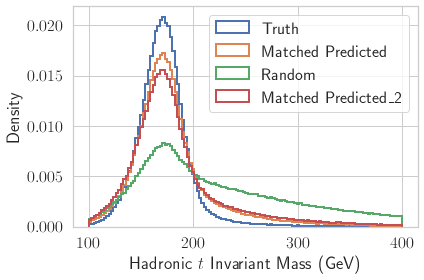

In [34]:
plot_distribution(invariant_mass(ht_momenta_true), line=2, label="Truth", range=(100, 400))
plot_distribution(invariant_mass(ht_momenta_pred), line=2, label="Matched Predicted", range=(100, 400))
plot_distribution(invariant_mass(ht_momenta_rand), line=2, label="Random", range=(100, 400))
# plot_distribution(invariant_mass(ht_momenta_unmatched), line=2, label="Umatched Predicted", range=(100, 400))

# plot_distribution(invariant_mass(ht_momenta_true_2), line=2, label="Truth_2", range=(100, 400))
plot_distribution(invariant_mass(ht_momenta_pred_2), line=2, label="Matched Predicted_2", range=(100, 400))
# plot_distribution(invariant_mass(ht_momenta_rand_2), line=2, label="Random_2", range=(100, 400))

plt.xlabel("Hadronic $t$ Invariant Mass (GeV)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout();

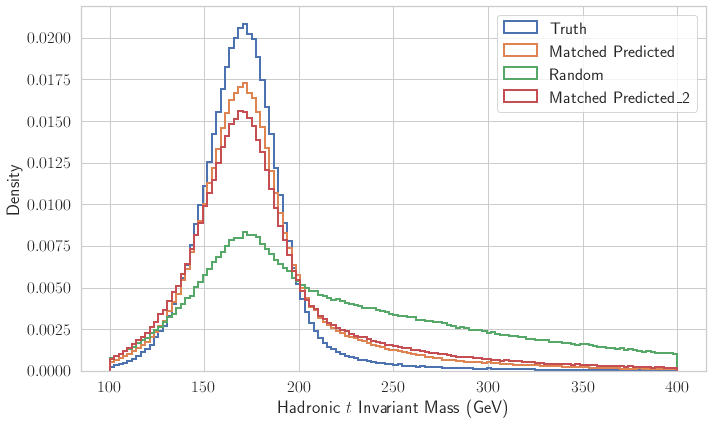

In [41]:
plt.figure(figsize=(10, 6))

plot_distribution(invariant_mass(ht_momenta_true), line=2, label="Truth", range=(100, 400))
plot_distribution(invariant_mass(ht_momenta_pred), line=2, label="Matched Predicted", range=(100, 400))
plot_distribution(invariant_mass(ht_momenta_rand), line=2, label="Random", range=(100, 400))
# plot_distribution(invariant_mass(ht_momenta_unmatched), line=2, label="Umatched Predicted", range=(100, 400))

# plot_distribution(invariant_mass(ht_momenta_true_2), line=2, label="Truth_2", range=(100, 400))
plot_distribution(invariant_mass(ht_momenta_pred_2), line=2, label="Matched Predicted_2", range=(100, 400))
# plot_distribution(invariant_mass(ht_momenta_rand_2), line=2, label="Random_2", range=(100, 400))

plt.xlabel("Hadronic $t$ Invariant Mass (GeV)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

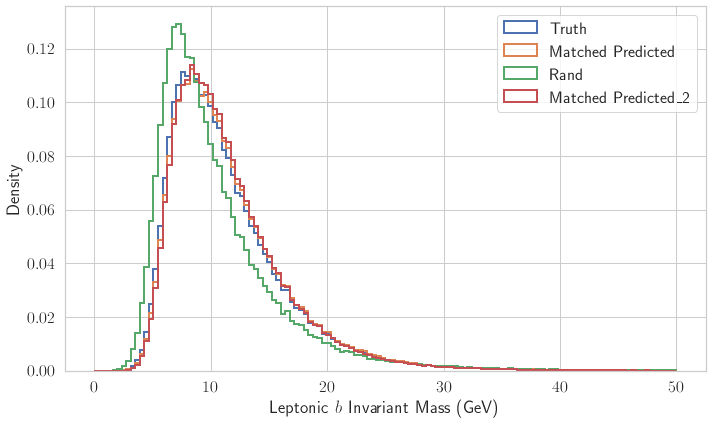

In [37]:
plt.figure(figsize=(10, 6))

plot_distribution(invariant_mass(lt_momenta_true), line=2, label="Truth", range=(0, 50))
plot_distribution(invariant_mass(lt_momenta_pred), line=2, label="Matched Predicted", range=(0, 50))
plot_distribution(invariant_mass(lt_momenta_rand), line=2, label="Rand", range=(0, 50))
# plot_distribution(invariant_mass(lt_momenta_unmatched), line=2, label="Umatched Predicted", range=(0, 50))

plot_distribution(invariant_mass(lt_momenta_pred_2), line=2, label="Matched Predicted_2", range=(0, 50))

plt.xlabel("Leptonic $b$ Invariant Mass (GeV)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
### creating ht_momenta_ak.com ### []
### creating lt_momenta_ak.com ###

In [ ]:
### have to convert h5 to constructe fou-momentum
### use four momentum to fo ak.combination to find the highest pt
### extract indices of the trijet
### use indices back to assignment_indices
### use assignment_indices for invariant_mass